In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import json
import csv
from pmdarima.arima import auto_arima
from prophet import Prophet

In [34]:
covid_data = pd.read_csv('owid-covid-data.csv')
covid_data.date = pd.to_datetime(covid_data.date)
covid_data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309659,ZWE,Africa,Zimbabwe,2023-05-06,264685.0,0.0,0.857,5686.0,0.0,0.143,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
309660,ZWE,Africa,Zimbabwe,2023-05-07,264685.0,0.0,0.286,5686.0,0.0,0.000,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
309661,ZWE,Africa,Zimbabwe,2023-05-08,264776.0,91.0,13.000,5689.0,3.0,0.429,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
309662,ZWE,Africa,Zimbabwe,2023-05-09,264776.0,0.0,13.000,5689.0,0.0,0.429,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN


In [35]:
france_covid = covid_data.query('location == "France"').reset_index(drop=True)[['date', 'new_cases']].set_index('date').fillna(0).astype(int)
france_covid

,new_cases
date,
2020-01-03,0
2020-01-04,0
2020-01-05,0
2020-01-06,0
2020-01-07,0
...,...
2023-05-07,5103
2023-05-08,3301
2023-05-09,759


In [36]:
germany_covid = covid_data.query('location == "Germany"').reset_index(drop=True)[['date', 'new_cases']].set_index('date').fillna(0).astype(int)
germany_covid

,new_cases
date,
2020-01-03,0
2020-01-04,1
2020-01-05,0
2020-01-06,0
2020-01-07,0
...,...
2023-05-09,0
2023-05-10,0
2023-05-11,0


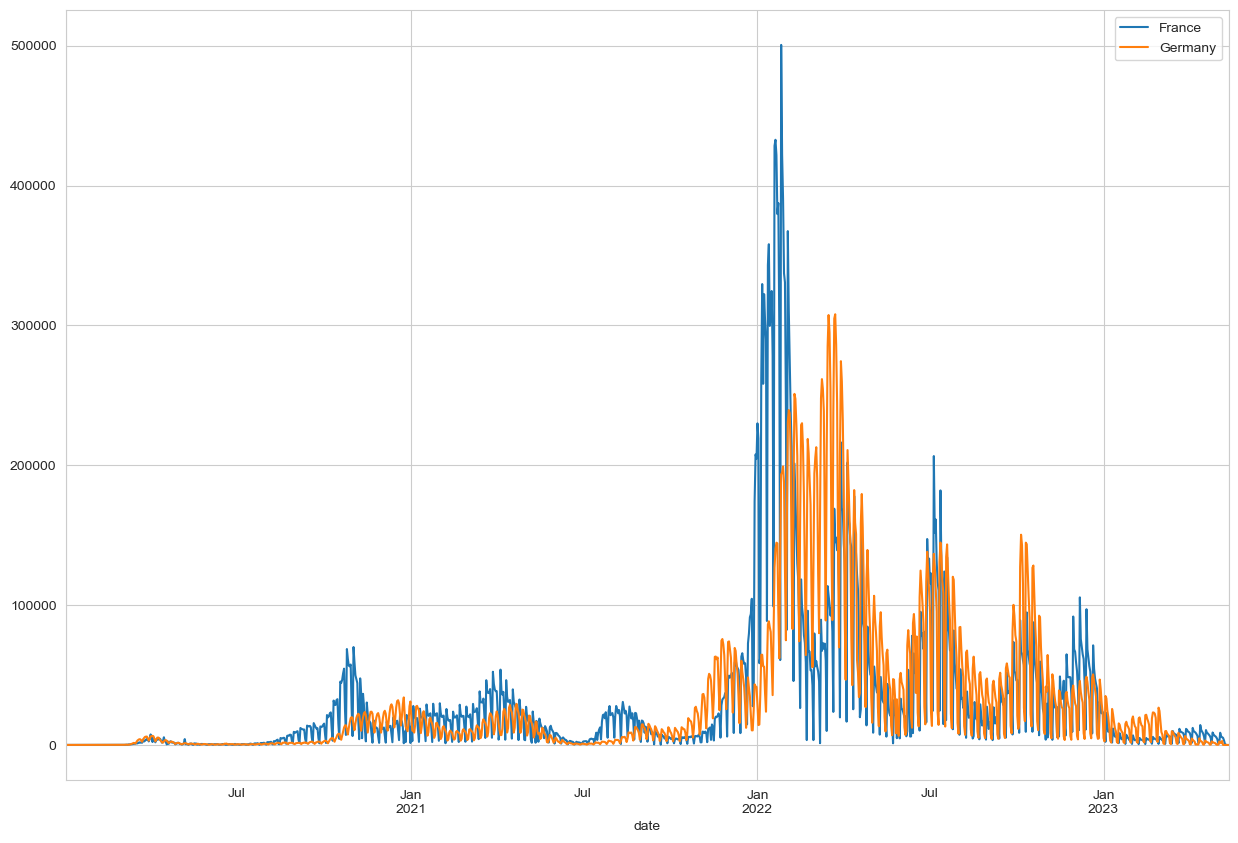

In [37]:
_, ax = plt.subplots(figsize=(15, 10))
france_covid.plot(ax=ax)
germany_covid.plot(ax=ax)
ax.legend(['France', 'Germany']);

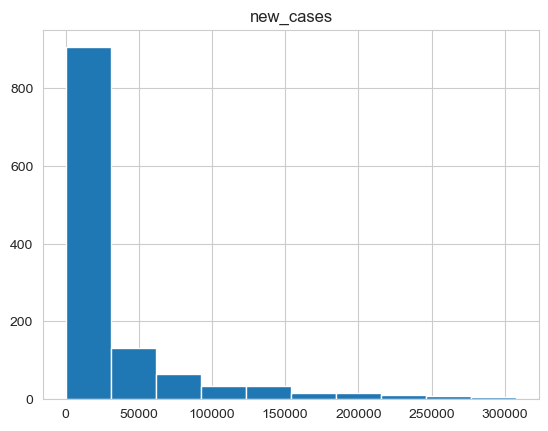

In [38]:
germany_covid.hist();

In [8]:
def plot_moving_average(series, n):
    rolling_mean = series.rolling(window=n).mean()
    plt.figure(figsize=(15, 5))
    plt.title(f'Moving average\n window size = {n}')
    plt.plot(series[n:], label='Actual values')
    plt.plot(rolling_mean, c='orange', label='Rolling mean trend')
    plt.legend(loc='upper left')
    plt.grid(True)

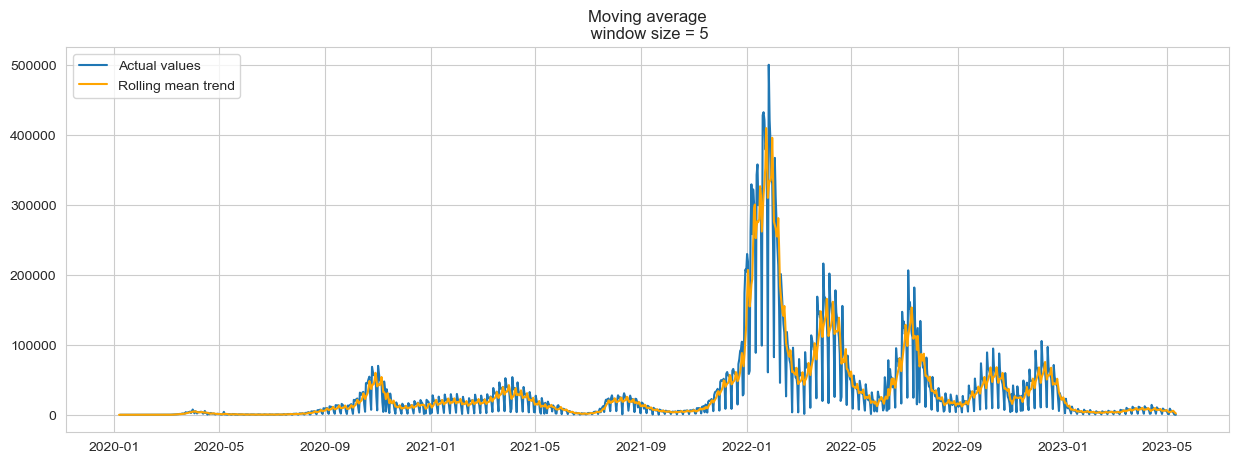

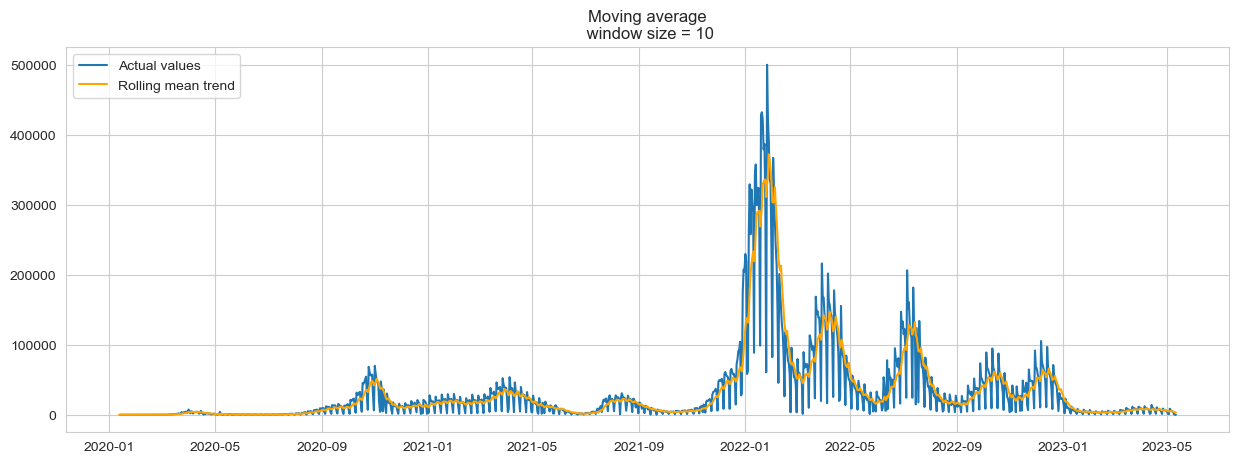

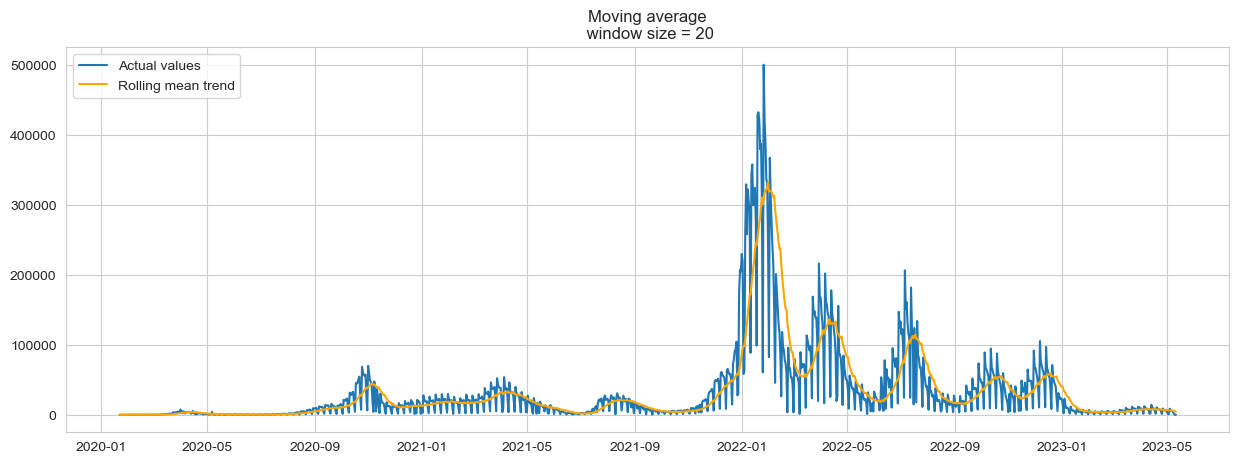

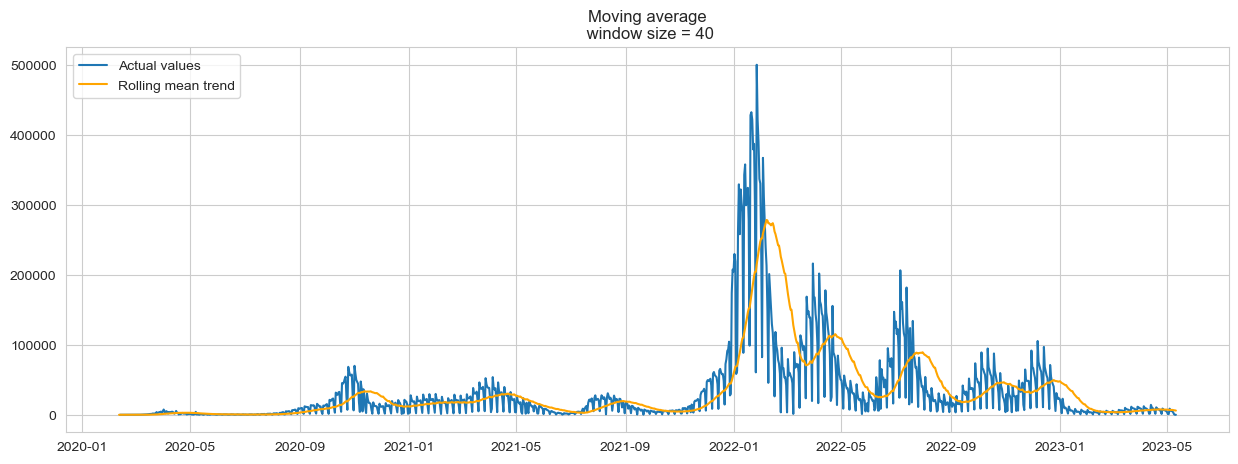

In [40]:
plot_moving_average(france_covid, 5)
plot_moving_average(france_covid, 10)
plot_moving_average(france_covid, 20)
plot_moving_average(france_covid, 40)

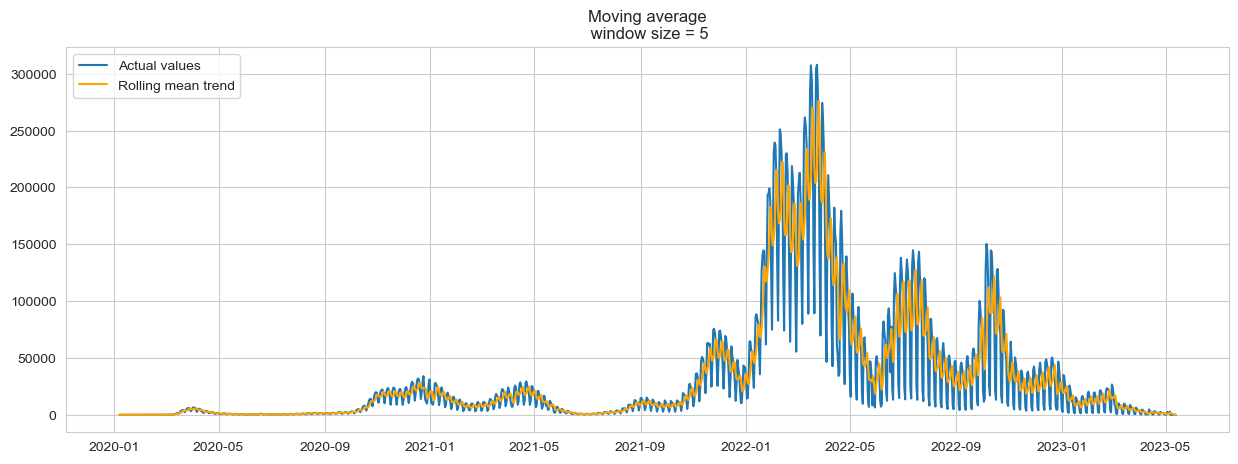

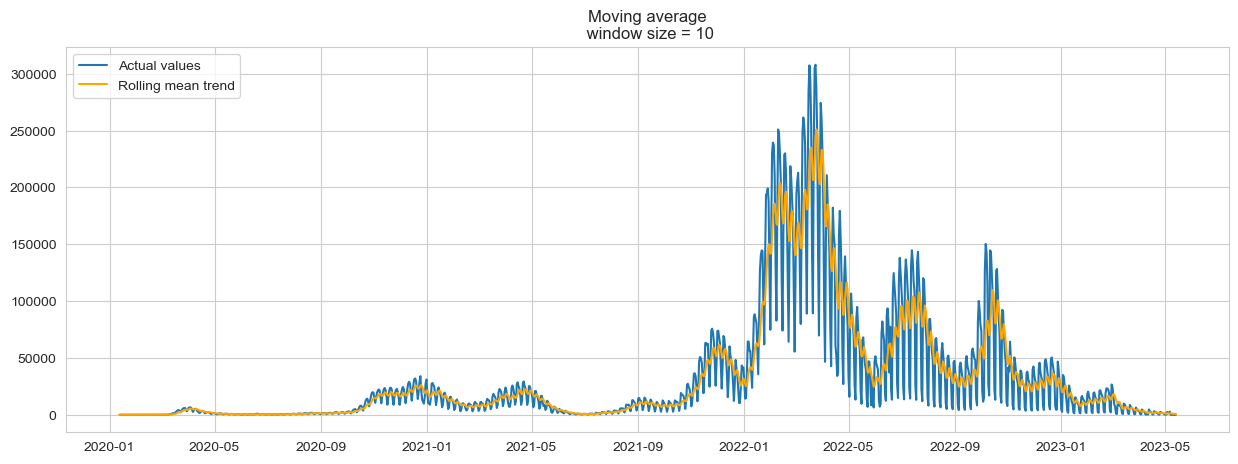

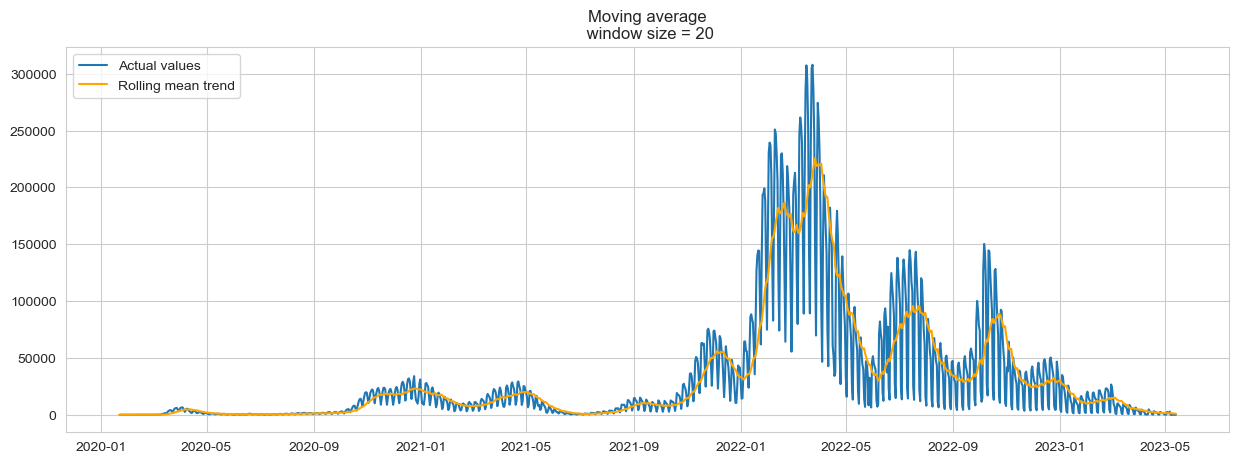

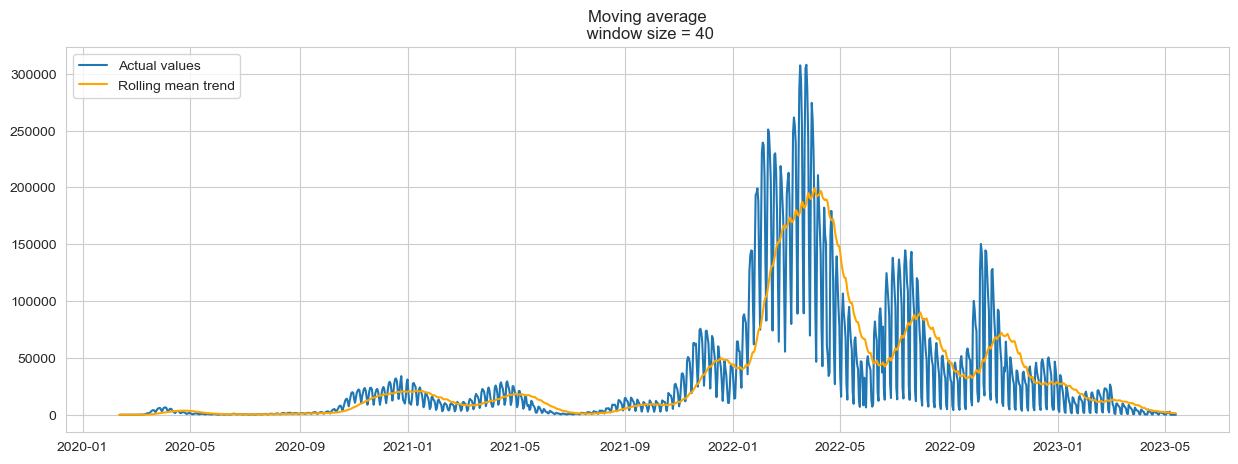

In [41]:
plot_moving_average(germany_covid, 5)
plot_moving_average(germany_covid, 10)
plot_moving_average(germany_covid, 20)
plot_moving_average(germany_covid, 40)

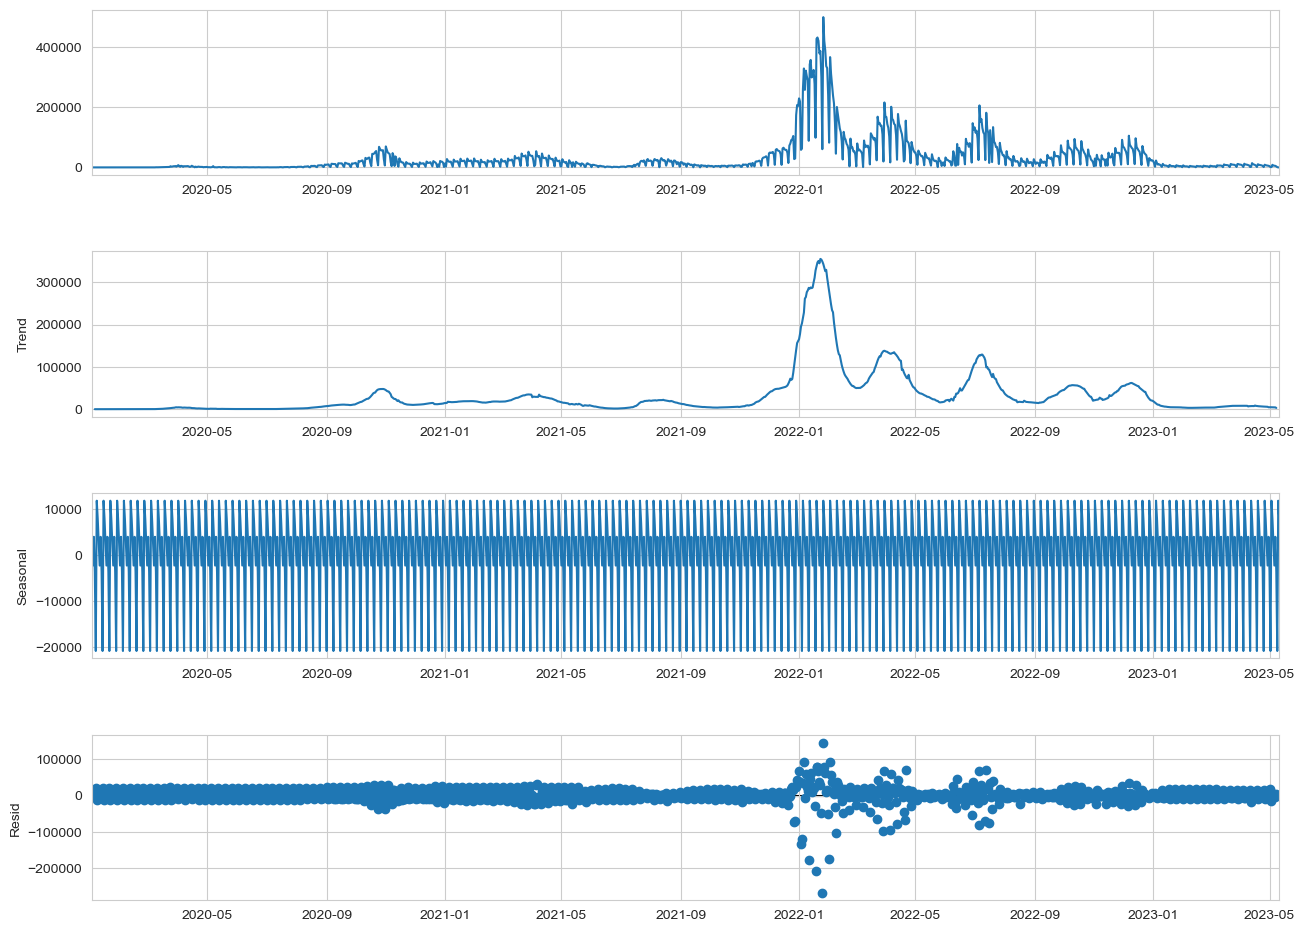

In [42]:
smt.seasonal_decompose(france_covid).plot().set_size_inches(15, 10)

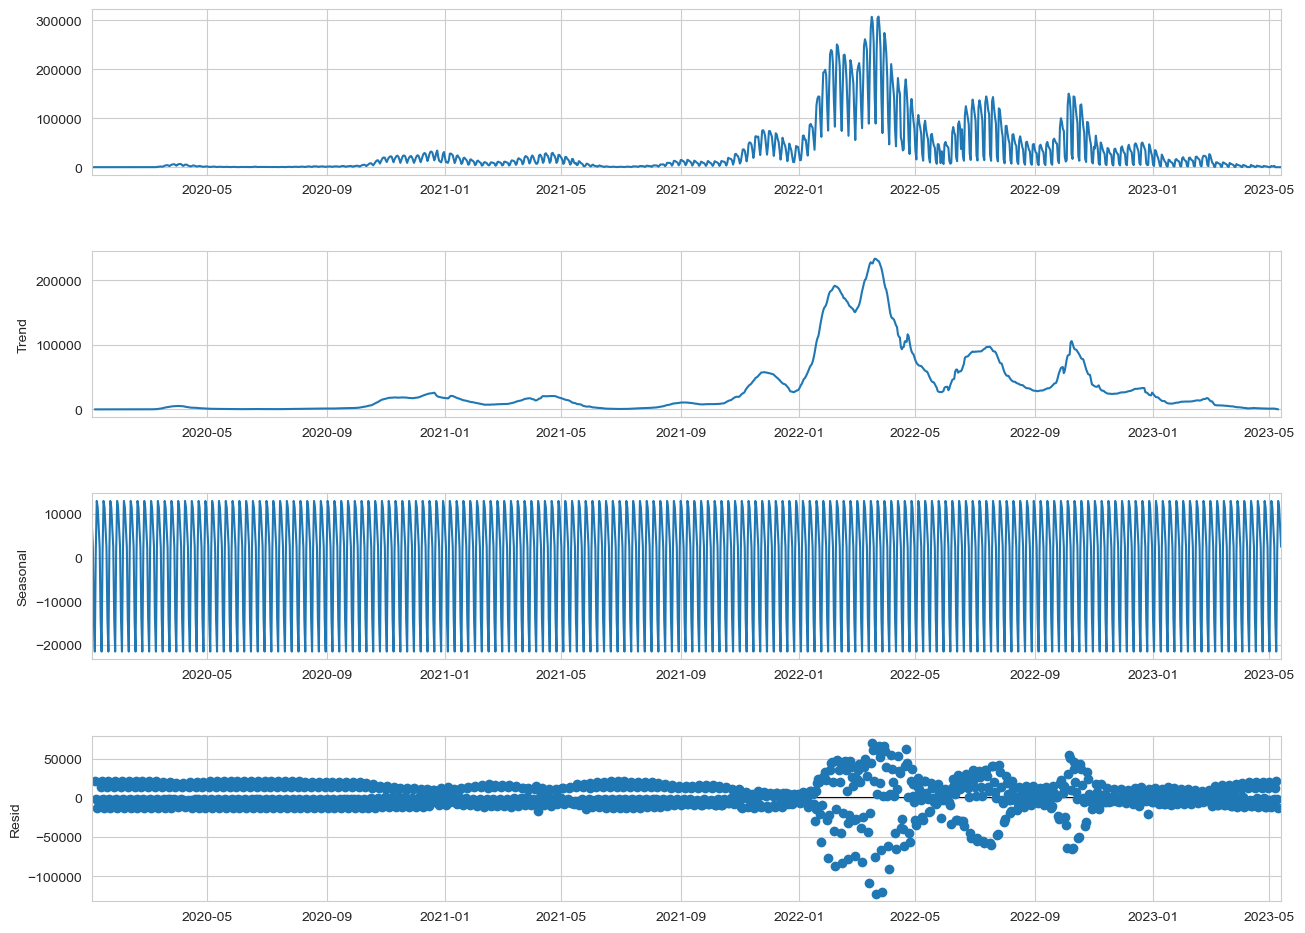

In [43]:
smt.seasonal_decompose(germany_covid).plot().set_size_inches(15, 10)

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


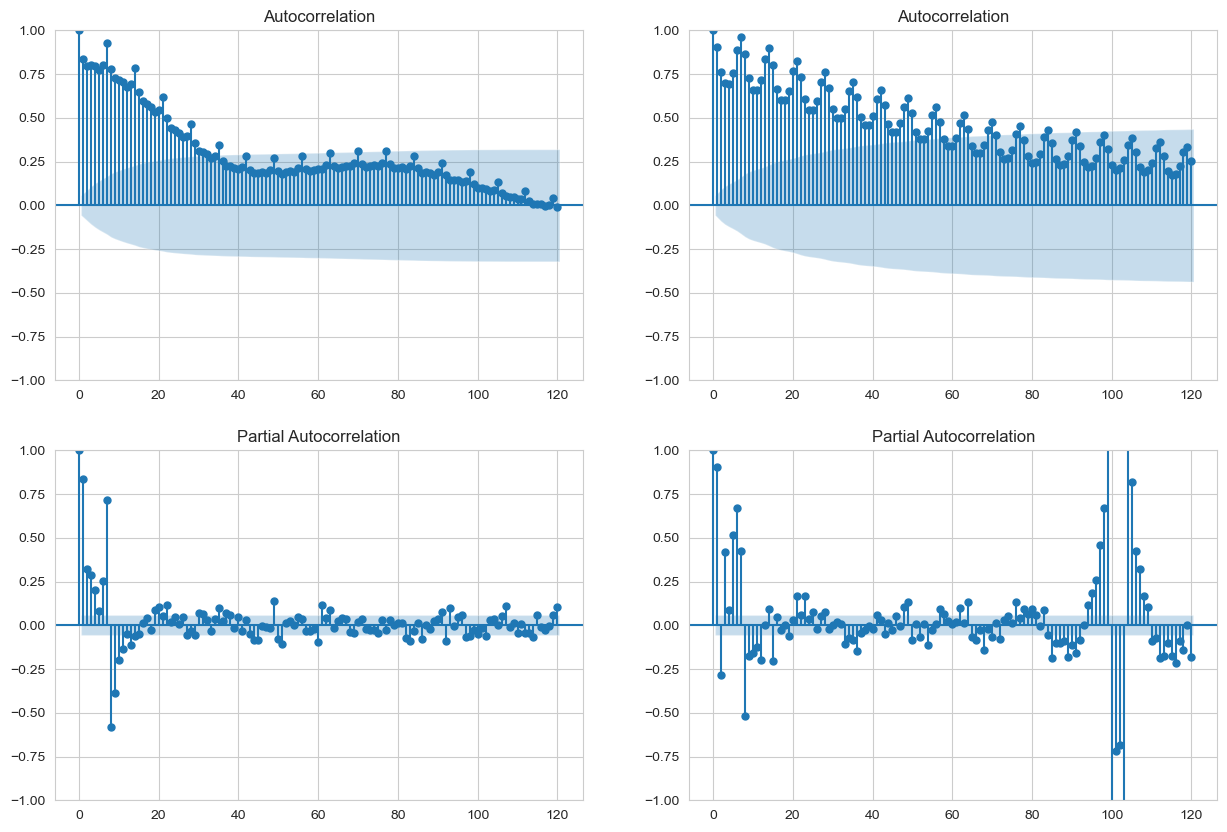

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0] = plot_acf(france_covid, ax=ax[0, 0], lags=120)
ax[1, 0] = plot_pacf(france_covid, ax=ax[1, 0], lags=120)
ax[0, 1] = plot_acf(germany_covid, ax=ax[0, 1], lags=120)
ax[1, 1] = plot_pacf(germany_covid, ax=ax[1, 1], lags=120)

In [13]:
def dickey_fuller_test(series):
    adf, p_value, usedlag, nobs, critical_vales, icbest = smt.adfuller(series, autolag='AIC')
    print('adf: ', adf)
    print('p-value: ', p_value)
    print('Critical values: ', critical_vales)
    if adf < critical_vales['5%'] and p_value < 0.05:
        print('Одиничні корені відсутні, ряд є стаціонарним.')
    else:
        print('Навні одиничні корені, ряд не стаціонарний.')

In [46]:
dickey_fuller_test(france_covid)

adf:  -3.868692363030866
p-value:  0.0022777244848204876
Critical values:  {'1%': -3.4357974716016093, '5%': -2.8639455255208186, '10%': -2.5680507439699447}
Одиничні корені відсутні, ряд є стаціонарним.


In [47]:
dickey_fuller_test(germany_covid)

adf:  -2.316427208258064
p-value:  0.1667245920076717
Critical values:  {'1%': -3.4357929374222222, '5%': -2.86394352510997, '10%': -2.5680496786183373}
Навні одиничні корені, ряд не стаціонарний.


In [3]:
with open('USD_UAH.json') as json_file:
    json_data = json.load(json_file)
with open('USD_UAH.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['date', 'buy', 'sell'])
    for date in list(json_data)[::-1]:
        data = json_data[date]
        if data:
            csv_writer.writerow([date, data['b'], data['s']])

In [4]:
usd_uah = pd.read_csv('USD_UAH.csv', index_col='date', parse_dates=['date'])
usd_uah.index = usd_uah.index.date
usd_uah.sort_index(inplace=True)
usd_uah

,buy,sell
2020-12-06,28.360000,28.405000
2020-12-07,28.250000,28.320000
2020-12-08,28.235000,28.290000
2020-12-09,28.170000,28.220000
2020-12-10,28.160000,28.200000
...,...,...
2023-05-10,37.668667,37.738000
2023-05-11,37.667667,37.733000
2023-05-12,37.661667,37.722333
2023-05-13,37.662000,37.726667


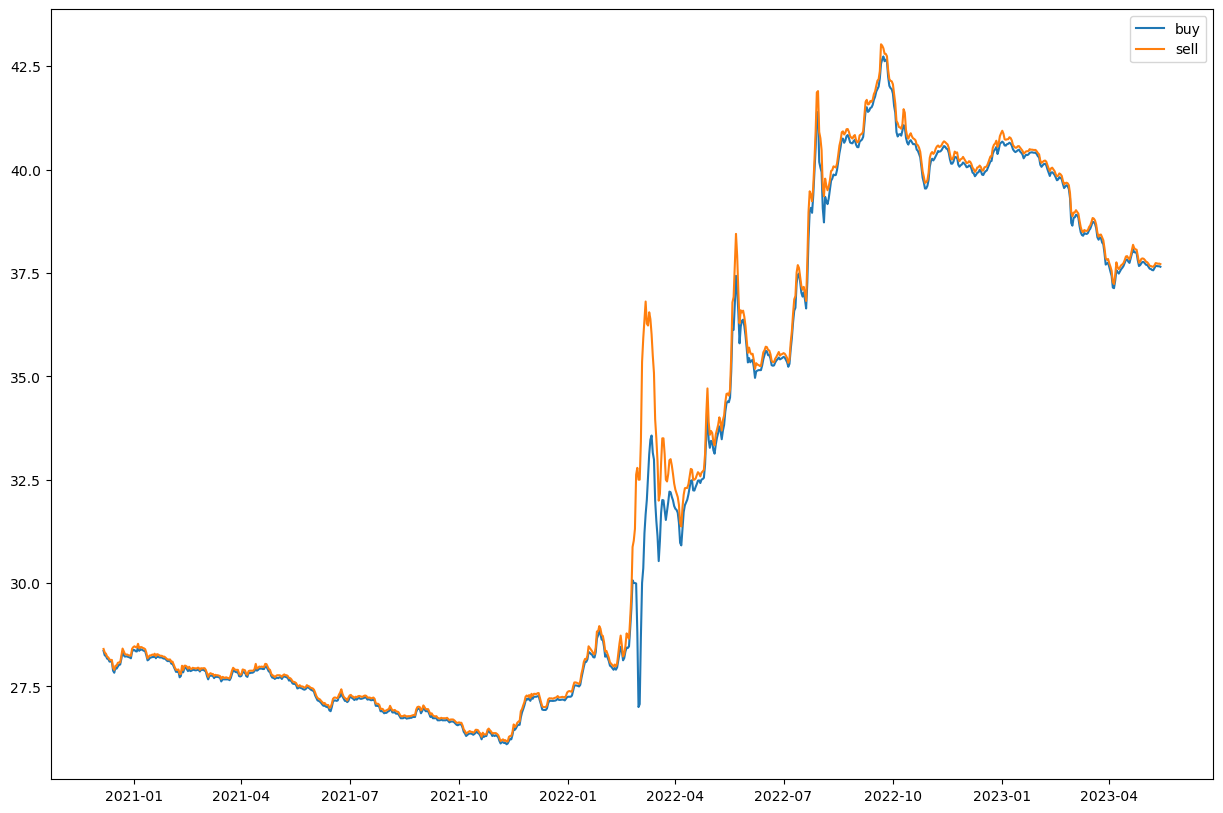

In [5]:
usd_uah.plot(figsize=(15, 10));

In [6]:
usd_uah.drop('buy', axis=1, inplace=True)
usd_uah

,sell
2020-12-06,28.405000
2020-12-07,28.320000
2020-12-08,28.290000
2020-12-09,28.220000
2020-12-10,28.200000
...,...
2023-05-10,37.738000
2023-05-11,37.733000
2023-05-12,37.722333
2023-05-13,37.726667


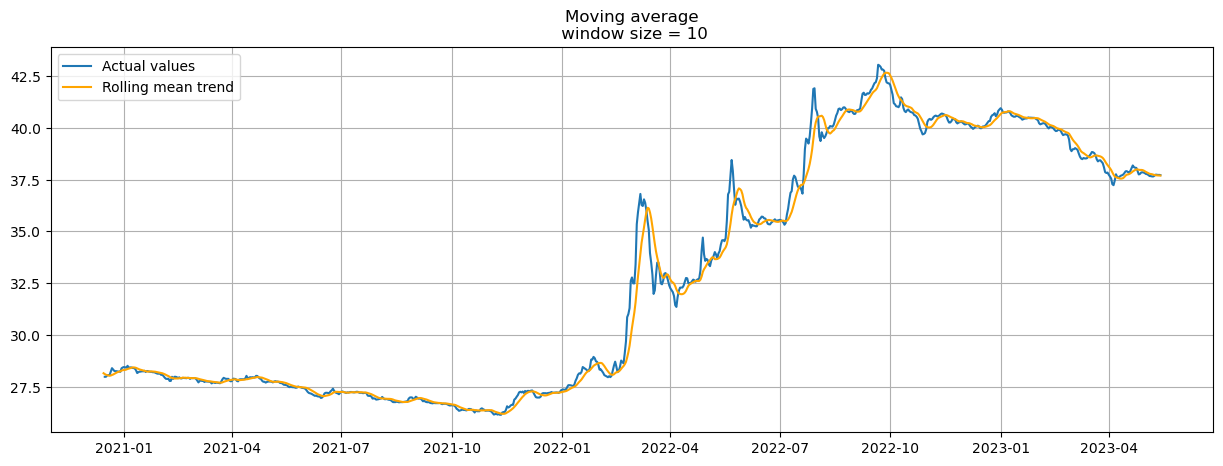

In [9]:
plot_moving_average(usd_uah, 10)

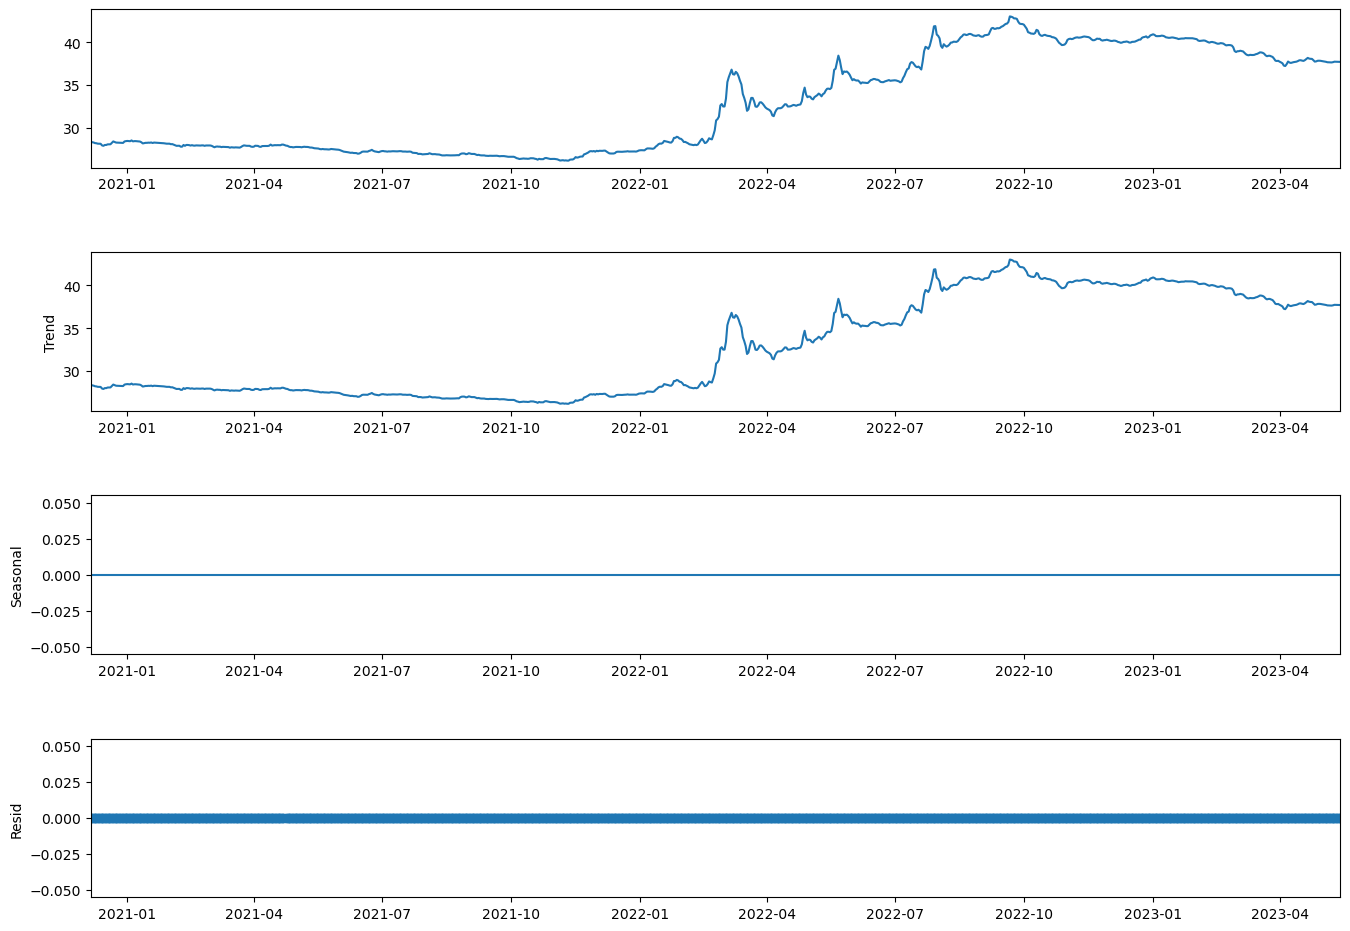

In [10]:
price_decomposition = smt.seasonal_decompose(usd_uah, period=1)
fig = price_decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()

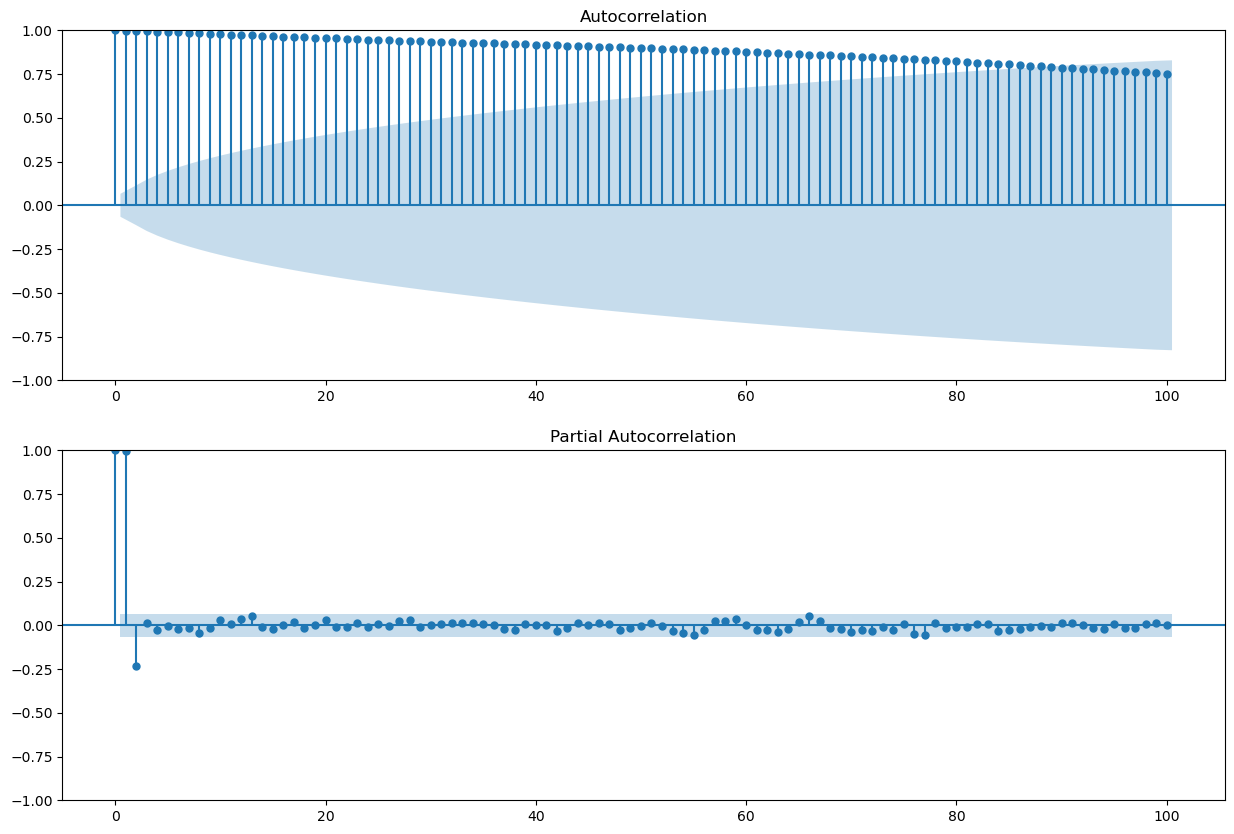

In [11]:
fig, ax = plt.subplots(2, figsize=(15, 10))
ax[0] = plot_acf(usd_uah, ax=ax[0], lags=100)
ax[1] = plot_pacf(usd_uah, ax=ax[1], lags=100, method='ywm')

In [14]:
dickey_fuller_test(usd_uah)

adf:  -0.7338149643917672
p-value:  0.8377952277275182
Critical values:  {'1%': -3.437888734710396, '5%': -2.8648678385823603, '10%': -2.5685419870524506}
Навні одиничні корені, ряд не стаціонарний.


In [15]:
usd_uah_diff = usd_uah.diff(periods=1).dropna()
usd_uah_diff

,sell
2020-12-07,-0.085000
2020-12-08,-0.030000
2020-12-09,-0.070000
2020-12-10,-0.020000
2020-12-11,-0.050000
...,...
2023-05-10,0.055333
2023-05-11,-0.005000
2023-05-12,-0.010667
2023-05-13,0.004333


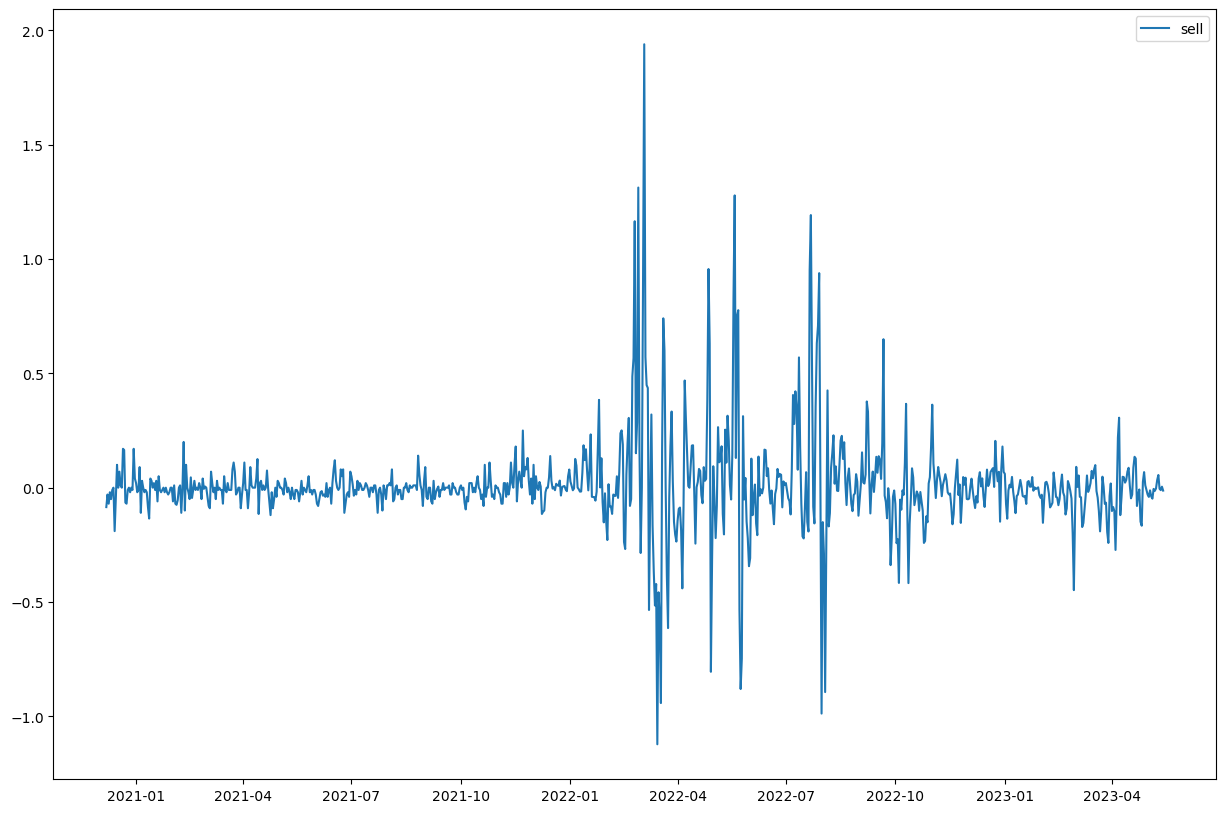

In [16]:
_, ax = plt.subplots(figsize=(15, 10))
usd_uah_diff.plot(ax=ax);

In [17]:
dickey_fuller_test(usd_uah_diff)

adf:  -7.1393665165044435
p-value:  3.355340899191478e-10
Critical values:  {'1%': -3.437888734710396, '5%': -2.8648678385823603, '10%': -2.5685419870524506}
Одиничні корені відсутні, ряд є стаціонарним.


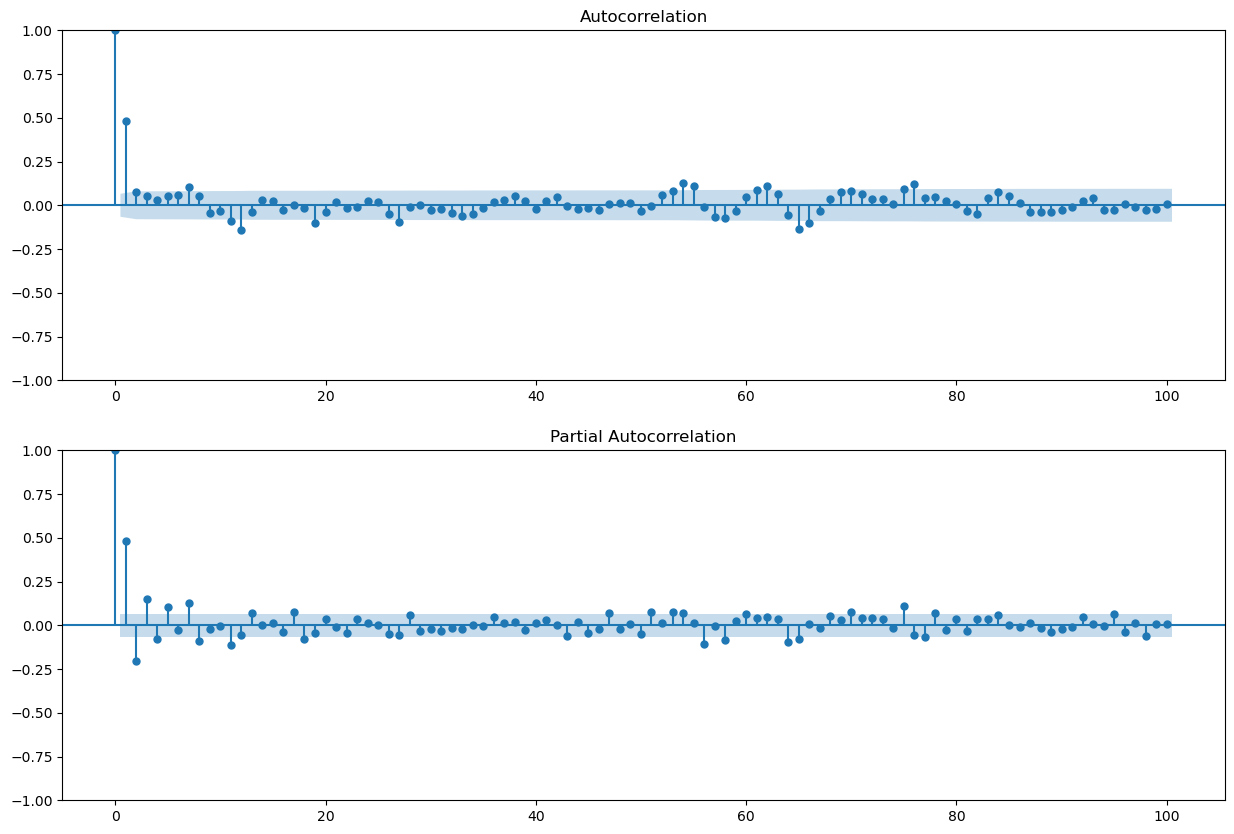

In [18]:
fig, ax = plt.subplots(2, figsize=(15, 10))
ax[0] = plot_acf(usd_uah_diff, ax=ax[0], lags=100)
ax[1] = plot_pacf(usd_uah_diff, ax=ax[1], lags=100, method='ywm')

In [19]:
model_stepwise = auto_arima(
    usd_uah,
    start_p=0,
    start_q=0,
    max_d=3,
    max_p=3,
    max_q=3,
    seasonal=True,
    m=12,
    start_P=0,
    d=None,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_stepwise.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=2638.301, Time=1.34 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2639.972, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=95.014, Time=3.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=7.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2650.570, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=429.027, Time=0.35 sec


KeyboardInterrupt: 

In [20]:
model = smt.ARIMA(usd_uah.sell, order=(1, 1, 1)).fit()

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
predictions = model.predict(10, start=usd_uah.index[0])
predictions

TypeError: MLEResults.predict() got multiple values for argument 'start'

In [ ]:
model_stepwise.arima_res_.get_forecast?

In [ ]:
predictions = model_stepwise.arima_res_.predict(start=15, end=usd_uah.shape[0] + 100, dynamic=False)
predictions.index = pd.to_datetime(usd_uah.index[0]) + pd.to_timedelta(predictions.index, unit='D')
predictions

In [ ]:
forecast = model_stepwise.arima_res_.get_forecast(100)
yhat = forecast.predicted_mean
yhat.index = pd.to_datetime(usd_uah.index[0]) + pd.to_timedelta(yhat.index, unit='D')
yhat_conf_int = forecast.conf_int(alpha=0.05)
yhat_conf_int.index = pd.to_datetime(usd_uah.index[0]) + pd.to_timedelta(yhat_conf_int.index, unit='D')
yhat_conf_int

In [ ]:
_, ax = plt.subplots(figsize=(15, 10))
ax.plot(usd_uah)
ax.plot(yhat);
ax.fill_between(x=yhat_conf_int.index, y1=yhat_conf_int['lower y'], y2=yhat_conf_int['upper y'], color='gray')

09:44:44 - cmdstanpy - INFO - Chain [1] start processing
09:44:44 - cmdstanpy - INFO - Chain [1] done processing


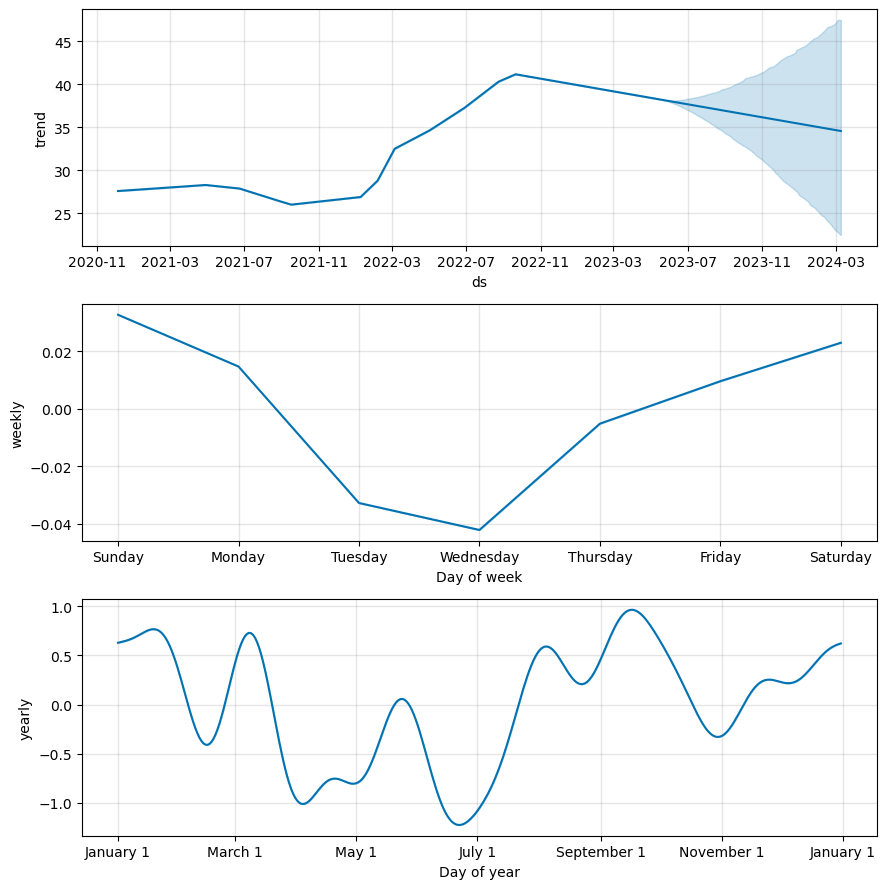

In [24]:
pmodel = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
train_df = pd.DataFrame.from_dict({
    'ds': usd_uah.index,
    'y': usd_uah.sell
})
pmodel.fit(train_df)
ppredictions = pmodel.predict(pmodel.make_future_dataframe(periods=300))
pmodel.plot_components(ppredictions);

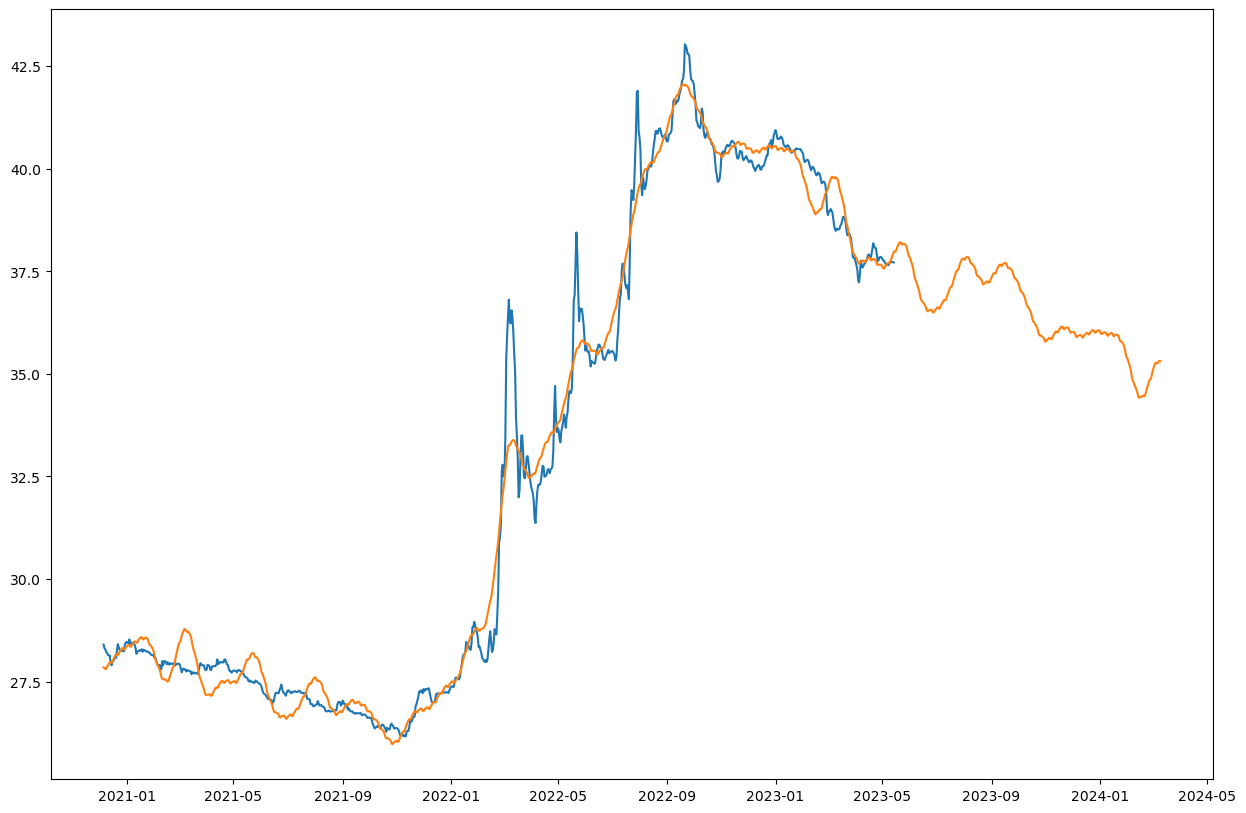

In [25]:
ppredictions = ppredictions.reset_index(drop=True).set_index('ds')
_, ax = plt.subplots(figsize=(15, 10))
ax.plot(usd_uah)
ax.plot(ppredictions.yhat);